# Ocean station Papa

This notebook checks the sensitivity of KPP-CVMix and GLS-C01A to the vertical resolution and time step in the [ocean station Papa](https://www.pmel.noaa.gov/ocs/Papa) case.

In [1]:
import sys
import numpy as np
import string
import matplotlib.pyplot as plt
# add the path of gotmtool
sys.path.append("../gotmtool")
from gotmtool import *
from gotmtool.diags import get_mld_deltaT

## Load data

First, store the information of the four simulations into lists and dictionaries.

In [2]:
turbmethod = 'KPP-CVMix'
# turbmethod = 'GLS-C01A'
casenames = [
    turbmethod+'_dz1m_dt60s',
    turbmethod+'_dz1m_dt600s',
    turbmethod+'_dz1m_dt1800s',
    turbmethod+'_dz5m_dt60s',
    turbmethod+'_dz5m_dt600s',
    turbmethod+'_dz5m_dt1800s',
    ]

rundates = {
    '2012-03-21': '2012-05-21',
    '2012-05-21': '2012-08-21',
    '2012-08-21': '2013-01-12',
    '2013-01-12': '2013-03-21',
    }

casedir = '../gotm/run/OSPapa_sensitivity'
save_fig = True

Load data for the four simulations and four stages into a dictionary.

In [3]:
sims = {}
dataset = {}
for case in casenames:
    sims0 = {}
    dataset0 = {}
    for start in rundates.keys():
        end = rundates[start]
        sim = Simulation(path=casedir+'/'+case+'_'+start+'_'+end)
        sims0[start] = sim
        dataset0[start] = sim.load_data()
    sims[case] = sims0
    dataset[case] = dataset0

## Figure

Hovmoller diagrams of the simulated temperature showing the differences with different vertical resolution and time step.

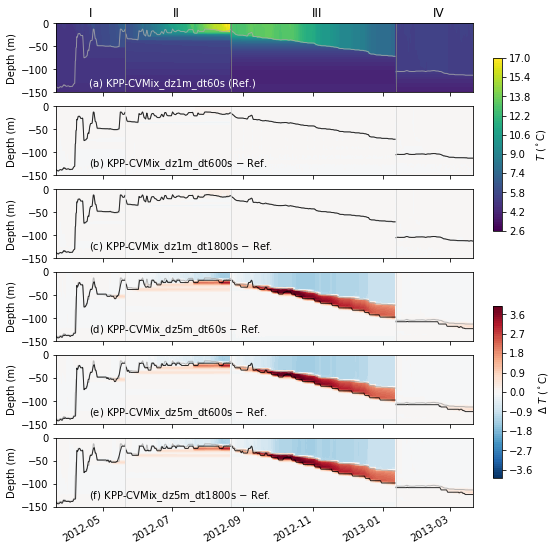

In [4]:
fig, axarr = plt.subplots(6, sharex='col')
fig.set_size_inches([8,8])

levels = np.linspace(2.6, 17, 73)
levels_diff = np.linspace(-4, 4, 81)
ref_case = casenames[0]
for i, start in enumerate(rundates.keys()):
    
    data0 = dataset[ref_case][start].temp[:,:,0,0]
    im0 = data0.plot.contourf(ax=axarr[0], levels=levels, add_colorbar=False)
    mld0 = -get_mld_deltaT(data0)
    mld0.rolling(time=8, center=True).mean().plot(
            ax=axarr[0], color='darkgray', linewidth=1, alpha=0.8)
    j = 0
    labels = [ref_case+' (Ref.)']
    for case in casenames:
        if case != ref_case:
            j += 1
            data1 = dataset[case][start].temp[:,:,0,0]
            diff = data1 - data0
            diff.attrs['long_name'] = '$\Delta$ '+ data0.attrs['long_name']
            diff.attrs['units'] = data0.attrs['units']
            im1 = diff.plot.contourf(ax=axarr[j], levels=levels_diff, add_colorbar=False)
            mld0.rolling(time=8, center=True).mean().plot(
                ax=axarr[j], color='darkgray', linewidth=1, alpha=0.8)
            mld1 = -get_mld_deltaT(data1)
            mld1.rolling(time=8, center=True).mean().plot(
                ax=axarr[j], color='k', linewidth=1, alpha=0.8)
            labels.append(case+' $-$ Ref.')
    
colors = ['w', 'k', 'k', 'k', 'k', 'k']
for j in np.arange(6):
    ax = axarr[j]
    ax.set_ylim([-150,0])
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('')
    ax.set_title('')
    ax.text(0.08, 0.05, '('+string.ascii_lowercase[j]+') '+labels[j],
            transform=ax.transAxes, color=colors[j],
            va='bottom', ha='left')
    
plt.subplots_adjust(top=0.94, bottom=0.1, right=0.85, hspace=0.2, wspace=0.15)

label_str = '$T$ ($^\circ$C)'
cax0 = plt.axes([0.8, 0.53, 0.1, 0.4])
cax0.set_visible(False)
cb0 = plt.colorbar(im0, ax=cax0)
cb0.formatter.set_powerlimits((-2, 2)) 
cb0.update_ticks()
cb0.set_label(label_str)
cax1 = plt.axes([0.8, 0.1, 0.1, 0.4])
cax1.set_visible(False)
cb1 = plt.colorbar(im1, ax=cax1)
cb1.formatter.set_powerlimits((-2, 2)) 
cb1.update_ticks()
cb1.set_label(r'$\Delta$ '+label_str)

axarr[0].text(0.083, 1.05, 'I', transform=axarr[0].transAxes,
              fontsize=12, va='bottom', ha='center')
axarr[0].text(0.29, 1.05, 'II', transform=axarr[0].transAxes,
              fontsize=12, va='bottom', ha='center')
axarr[0].text(0.625, 1.05, 'III', transform=axarr[0].transAxes,
              fontsize=12, va='bottom', ha='center')
axarr[0].text(0.917, 1.05, 'IV', transform=axarr[0].transAxes,
              fontsize=12, va='bottom', ha='center')

startdate = list(rundates.keys())
for i, ax in enumerate(axarr):
    if i == 0:
        cl = 'gray'
    else:
        cl = 'lightgray'
    ax.axvline(np.datetime64(startdate[1]), color=cl, linewidth=0.75)
    ax.axvline(np.datetime64(startdate[2]), color=cl, linewidth=0.75)
    ax.axvline(np.datetime64(startdate[3]), color=cl, linewidth=0.75)

if save_fig:
    figname = 'ospapa_sensitivity_'+turbmethod+'.pdf'
    fig.savefig(figname, dpi=300)